<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    SENTIMENT ANALYSIS
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Dictionary-based methods
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Maciej Świtała, PhD
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:50px;">
    Autumn 2025
  </div>

  <!-- Logo -->
  <div>
    <img src="img/wne-logo-new-en.jpg" alt="WNE Logo" style="max-width:400px; height:auto;">
  </div>
</div>


### 1. Intro

In [48]:
# !pip install pandas matplotlib nltk afinn textblob

In [126]:
import pandas as pd  # for working with data in DataFrames
import matplotlib.pyplot as plt  # data visualization

import pickle  # data loading
import re

import nltk
# nltk.download('sentiwordnet')
# nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn # SentiWordNet algorithm
from nltk.sentiment import SentimentIntensityAnalyzer # VADER algorithm

from afinn import Afinn # AFINN algorithm
from textblob import TextBlob # for Pattern framework implementation

In [50]:
# let us load an example dataset; these are opinions on an individual McDonald's restaurant in the U.S.
with open("data/nichecom-opinions-mcdonalds.txt", "rb") as fp:
    data = pickle.load(fp)

In [51]:
# initial inspection of the first five news
data.head()

,Review,Rating,Position,Date
0,working for McDonald's is very unique you lear...,Rating 4 out of 5,Senior Employee,2024-09-30
1,It have been great so far. The people are real...,Rating 3 out of 5,Entry Level Employee,2024-09-12
2,The Mcdonalds that I work at is a very good jo...,Rating 3 out of 5,Manager / Director,2024-09-09
3,While the workplace environment may not be per...,Rating 2 out of 5,Intern / Student Worker,2024-06-10
4,The overall experience of working at a McDonal...,Rating 3 out of 5,Other,2024-05-31


In [52]:
# let us remove empty reviews
data = data[data['Review'].map(lambda x: len(x)>0)]

In [53]:
data.shape

(472, 4)

### 2. SentiWordNet

In [54]:
# SentiWordNet is a fundamental algorithm, still not very common nowadays as it works on single words that have different scores dependning on their meanings;
# it is hard to decide which meaning is accurate (unless the considered data are very specific) and how to aggregate the results properly

word = 'love'
synsets = list(swn.senti_synsets(word))

for synset in synsets:
    print(word+', synset: '+synset.synset.name()+', pos. score: '+str(synset.pos_score())+', neg. score: '+str(synset.neg_score())+', obj. score: '+str(synset.obj_score()))

love, synset: love.n.01, pos. score: 0.625, neg. score: 0.0, obj. score: 0.375
love, synset: love.n.02, pos. score: 0.375, neg. score: 0.0, obj. score: 0.625
love, synset: beloved.n.01, pos. score: 0.125, neg. score: 0.0, obj. score: 0.875
love, synset: love.n.04, pos. score: 0.25, neg. score: 0.0, obj. score: 0.75
love, synset: love.n.05, pos. score: 0.0, neg. score: 0.0, obj. score: 1.0
love, synset: sexual_love.n.02, pos. score: 0.0, neg. score: 0.0, obj. score: 1.0
love, synset: love.v.01, pos. score: 0.5, neg. score: 0.0, obj. score: 0.5
love, synset: love.v.02, pos. score: 1.0, neg. score: 0.0, obj. score: 0.0
love, synset: love.v.03, pos. score: 0.625, neg. score: 0.0, obj. score: 0.375
love, synset: sleep_together.v.01, pos. score: 0.375, neg. score: 0.125, obj. score: 0.5


In [55]:
# let us try aggregation per piece of text (it involves simplifications and is in general not advised; here we do it only for educational purposes)

def sentiwordnet_overall_sentiment(sentence):
    words = word_tokenize(sentence)
    sentiment_scores = 0
    for word in words:
        synsets = list(swn.senti_synsets(word))
        if synsets: # if there are any synsets
            # important limitation: here we take the first synset (probably the most common);
            # definitely, some rules should be established, however it highly depends on the data;
            # if we have a priori knowledge about the data, we can specify the meaning we want to score
            # however, it appears not very efficient
            synset = synsets[0]
            sentiment_scores = sentiment_scores + synset.pos_score() - synset.neg_score()
    return sentiment_scores

In [56]:
sentence = "I hate programming in Python. I cannot understand the lambda function. What the heck?"
print(sentence)

score = sentiwordnet_overall_sentiment(sentence)
print('positive score:',round(score,2))

I hate programming in Python. I cannot understand the lambda function. What the heck?
positive score: -0.5


In [57]:
sentence = "I love programming in Python. I understand the lambda function."
print(sentence)

score = sentiwordnet_overall_sentiment(sentence)
print('positive score:',round(score,2))

I love programming in Python. I understand the lambda function.
positive score: 1.0


In [58]:
sentence = "I absolutely love programming in Python. I understand the lambda function."
print(sentence)

score = sentiwordnet_overall_sentiment(sentence)
print('positive score:',round(score,2))

I absolutely love programming in Python. I understand the lambda function.
positive score: 1.5


In [59]:
sentence = "I absolutely LOVE programming in Python. I understand the lambda function."
print(sentence)

score = sentiwordnet_overall_sentiment(sentence)
print('positive score:',round(score,2))

I absolutely LOVE programming in Python. I understand the lambda function.
positive score: 1.5


In [60]:
data['Review_sentiwordnet_overall_sentiment'] = data['Review'].apply(sentiwordnet_overall_sentiment)

In [61]:
data['Review_sentiwordnet_overall_sentiment'].describe()

count    472.000000
mean       0.964513
std        1.380717
min       -5.250000
25%        0.125000
50%        1.000000
75%        1.750000
max        5.875000
Name: Review_sentiwordnet_overall_sentiment, dtype: float64

<Axes: >

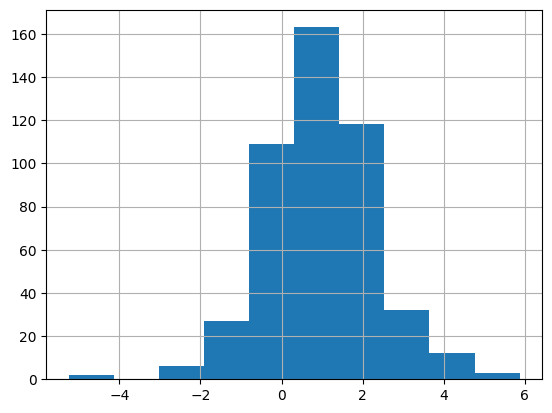

In [62]:
data['Review_sentiwordnet_overall_sentiment'].hist()

Text(0, 0.5, 'Rating')

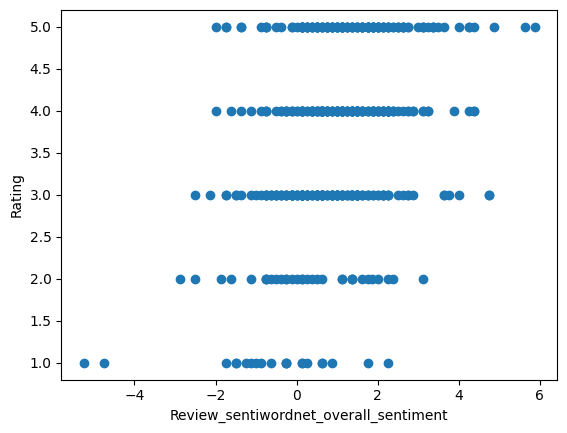

In [63]:
plt.scatter(data['Review_sentiwordnet_overall_sentiment'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('Review_sentiwordnet_overall_sentiment')
plt.ylabel('Rating')

In [68]:
# worst opinions
worst_opinions = (
    data
    .sort_values(by="Review_sentiwordnet_overall_sentiment", ascending=True)
    .head(3)[["Review", "Review_sentiwordnet_overall_sentiment"]]
)

worst_opinions

,Review,Review_sentiwordnet_overall_sentiment
443,"Ugh, Mcdonalds was the worst experience of my ...",-5.250
23,My God I did the biggest mistake in my life wo...,-4.750
409,It depends on your location and coworkers whet...,-2.875


In [69]:
# best opinions
best_opinions = (
    data
    .sort_values(by="Review_sentiwordnet_overall_sentiment", ascending=False)
    .head(3)[["Review", "Review_sentiwordnet_overall_sentiment"]]
)

best_opinions

,Review,Review_sentiwordnet_overall_sentiment
36,I have very good experience working at Mcdoanl...,5.875
53,I have been working at McDonald’s for about a ...,5.625
362,"McDonald's is a great place to work, especiall...",4.875


### 3. AFINN

In [70]:
# AFINN offers an aggregated score per text; it does not take context into account, only 'raw' words (scored from -5 to 5, then aggregated)
afinn = Afinn()

text = "love"
score = afinn.score(text)
score

3.0

In [71]:
afinn = Afinn()

text = "hate"
score = afinn.score(text)
score

-3.0

In [72]:
afinn = Afinn()

text = "I love programming but hate debugging."
score = afinn.score(text)
score

0.0

In [ ]:
# the score is just a sum of per token scores:
for token in text.split(' '):
    score = afinn.score(token); print(token,'-',score)

I - 0.0
love - 3.0
programming - 0.0
but - 0.0
hate - -3.0
debugging. - 0.0


In [74]:
afinn = Afinn()

text = "He loves programming but hate debugging."
score = afinn.score(text)
score

0.0

In [75]:
for token in text.split(' '):
    score = afinn.score(token); print(token,'-',score)

He - 0.0
loves - 3.0
programming - 0.0
but - 0.0
hate - -3.0
debugging. - 0.0


In [76]:
afinn = Afinn()

text = "He absolutely loves programming but hate debugging."
score = afinn.score(text)
score

0.0

In [77]:
for token in text.split(' '):
    score = afinn.score(token); print(token,'-',score)

He - 0.0
absolutely - 0.0
loves - 3.0
programming - 0.0
but - 0.0
hate - -3.0
debugging. - 0.0


In [78]:
afinn = Afinn()

text = "He absolutely LOVES <3 programming but hate debugging..."
score = afinn.score(text)
score

0.0

In [79]:
for token in text.split(' '):
    score = afinn.score(token); print(token,'-',score)

He - 0.0
absolutely - 0.0
LOVES - 3.0
<3 - 0.0
programming - 0.0
but - 0.0
hate - -3.0
debugging... - 0.0


In [80]:
# more interesting example (one of the scraped opinions):
print('Review #0:',data['Review'][0])

text = data['Review'][0]
score = afinn.score(text)
score

Review #0: working for McDonald's is very unique you learn a lot of things and you get to enjoy becoming friends with coworkers


2.0

In [81]:
for token in data['Review'][0].split(' '):
    score = afinn.score(token); print(token,'-',score)

working - 0.0
for - 0.0
McDonald's - 0.0
is - 0.0
very - 0.0
unique - 0.0
you - 0.0
learn - 0.0
a - 0.0
lot - 0.0
of - 0.0
things - 0.0
and - 0.0
you - 0.0
get - 0.0
to - 0.0
enjoy - 2.0
becoming - 0.0
friends - 0.0
with - 0.0
coworkers - 0.0


In [82]:
print('Review #3:',data['Review'][3])

text = data['Review'][3]
score = afinn.score(text)
score

Review #3: While the workplace environment may not be perfect, the team I work with is truly amazing. Wished many things were changed as well to make work easy and least hard.


7.0

In [83]:
for token in data['Review'][3].split(' '):
    score = afinn.score(token); print(token,'-',score)

While - 0.0
the - 0.0
workplace - 0.0
environment - 0.0
may - 0.0
not - 0.0
be - 0.0
perfect, - 3.0
the - 0.0
team - 0.0
I - 0.0
work - 0.0
with - 0.0
is - 0.0
truly - 0.0
amazing. - 4.0
Wished - 0.0
many - 0.0
things - 0.0
were - 0.0
changed - 0.0
as - 0.0
well - 0.0
to - 0.0
make - 0.0
work - 0.0
easy - 1.0
and - 0.0
least - 0.0
hard. - -1.0


In [84]:
data['Review_AFINN_sentiment'] = data['Review'].apply(afinn.score)

In [85]:
data['Review_AFINN_sentiment'].describe()

count    472.000000
mean       5.084746
std        5.813194
min      -20.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       33.000000
Name: Review_AFINN_sentiment, dtype: float64

<Axes: >

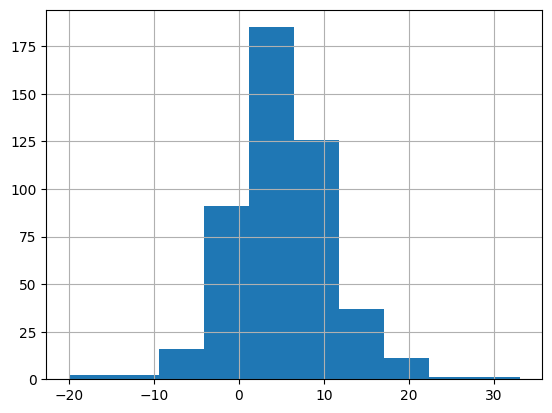

In [86]:
data['Review_AFINN_sentiment'].hist()

Text(0, 0.5, 'Rating')

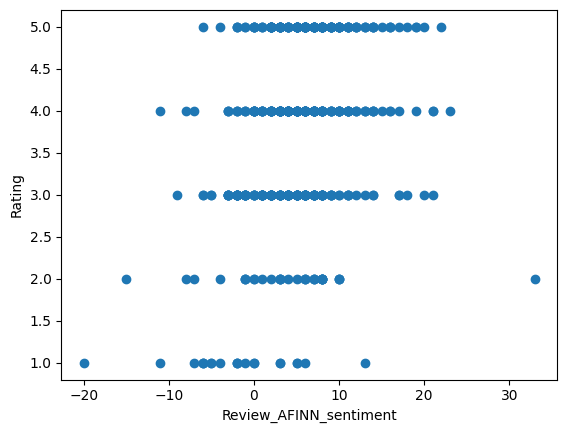

In [87]:
plt.scatter(data['Review_AFINN_sentiment'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('Review_AFINN_sentiment')
plt.ylabel('Rating')

In [88]:
# worst opinions
worst_opinions = (
    data
    .sort_values(by="Review_AFINN_sentiment", ascending=True)
    .head(3)[["Review", "Review_AFINN_sentiment"]]
)

worst_opinions

,Review,Review_AFINN_sentiment
443,"Ugh, Mcdonalds was the worst experience of my ...",-20.0
451,I worked at McDonald's for three months and it...,-15.0
23,My God I did the biggest mistake in my life wo...,-11.0


In [89]:
# best opinions
best_opinions = (
    data
    .sort_values(by="Review_AFINN_sentiment", ascending=False)
    .head(3)[["Review", "Review_AFINN_sentiment"]]
)

best_opinions

,Review,Review_AFINN_sentiment
11,Not great.Not great.Not great.Not great.Not gr...,33.0
46,The work environment is very nice and the trea...,23.0
169,Very lovely been around for years the people a...,22.0


### 4. The Pattern framework

In [90]:
# Pattern implementation in TextBlob returns sentiment polarisation score (from -1 to +1) and subjectivity score (from 0 to 1); 
# it works well with formal texts such as articles, reviews, but is less adept at analysing short, loose texts;
# in particular it is less effective for colloquial text, slang and social media

text = "I love this movie, it was fantastic"

blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.45, subjectivity=0.75)


In [ ]:
# the score is just an average of non-zero token scores:
for token in text.split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

I - Sentiment(polarity=0.0, subjectivity=0.0)
love - Sentiment(polarity=0.5, subjectivity=0.6)
this - Sentiment(polarity=0.0, subjectivity=0.0)
movie, - Sentiment(polarity=0.0, subjectivity=0.0)
it - Sentiment(polarity=0.0, subjectivity=0.0)
was - Sentiment(polarity=0.0, subjectivity=0.0)
fantastic - Sentiment(polarity=0.4, subjectivity=0.9)


In [104]:
text = "He loves this movie, it was fantastic"
text = re.sub(",", '', text)
print(text)

blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

He loves this movie it was fantastic
Sentiment(polarity=0.4, subjectivity=0.9)


In [ ]:
for token in text.split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

He - Sentiment(polarity=0.0, subjectivity=0.0)
loves - Sentiment(polarity=0.0, subjectivity=0.0)
this - Sentiment(polarity=0.0, subjectivity=0.0)
movie - Sentiment(polarity=0.0, subjectivity=0.0)
it - Sentiment(polarity=0.0, subjectivity=0.0)
was - Sentiment(polarity=0.0, subjectivity=0.0)
fantastic - Sentiment(polarity=0.4, subjectivity=0.9)


In [106]:
text = "He loves this movie, it was fantastic"
text = text+'!!!'
print(text)

blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

He loves this movie, it was fantastic!!!
Sentiment(polarity=0.78125, subjectivity=0.9)


In [ ]:
for token in text.split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

He - Sentiment(polarity=0.0, subjectivity=0.0)
loves - Sentiment(polarity=0.0, subjectivity=0.0)
this - Sentiment(polarity=0.0, subjectivity=0.0)
movie, - Sentiment(polarity=0.0, subjectivity=0.0)
it - Sentiment(polarity=0.0, subjectivity=0.0)
was - Sentiment(polarity=0.0, subjectivity=0.0)
fantastic!!! - Sentiment(polarity=0.78125, subjectivity=0.9)


In [102]:
text = "He loves this movie, it was fantastic"
text = text+' :)'
print(text)

blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

He loves this movie, it was fantastic :)
Sentiment(polarity=0.45, subjectivity=0.95)


In [ ]:
for token in text.split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

He - Sentiment(polarity=0.0, subjectivity=0.0)
loves - Sentiment(polarity=0.0, subjectivity=0.0)
this - Sentiment(polarity=0.0, subjectivity=0.0)
movie, - Sentiment(polarity=0.0, subjectivity=0.0)
it - Sentiment(polarity=0.0, subjectivity=0.0)
was - Sentiment(polarity=0.0, subjectivity=0.0)
fantastic!!! - Sentiment(polarity=0.78125, subjectivity=0.9)


In [111]:
# more interesting example (one of the analysed opinions)
print('Review #0:',data['Review'][0])

blob = TextBlob(data['Review'][0])
sentiment = blob.sentiment
print(sentiment)

Review #0: working for McDonald's is very unique you learn a lot of things and you get to enjoy becoming friends with coworkers
Sentiment(polarity=0.44583333333333336, subjectivity=0.7833333333333333)


In [112]:
for token in data['Review'][0].split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

working - Sentiment(polarity=0.0, subjectivity=0.0)
for - Sentiment(polarity=0.0, subjectivity=0.0)
McDonald's - Sentiment(polarity=0.0, subjectivity=0.0)
is - Sentiment(polarity=0.0, subjectivity=0.0)
very - Sentiment(polarity=0.2, subjectivity=0.3)
unique - Sentiment(polarity=0.375, subjectivity=1.0)
you - Sentiment(polarity=0.0, subjectivity=0.0)
learn - Sentiment(polarity=0.0, subjectivity=0.0)
a - Sentiment(polarity=0.0, subjectivity=0.0)
lot - Sentiment(polarity=0.0, subjectivity=0.0)
of - Sentiment(polarity=0.0, subjectivity=0.0)
things - Sentiment(polarity=0.0, subjectivity=0.0)
and - Sentiment(polarity=0.0, subjectivity=0.0)
you - Sentiment(polarity=0.0, subjectivity=0.0)
get - Sentiment(polarity=0.0, subjectivity=0.0)
to - Sentiment(polarity=0.0, subjectivity=0.0)
enjoy - Sentiment(polarity=0.4, subjectivity=0.5)
becoming - Sentiment(polarity=0.45, subjectivity=0.8500000000000001)
friends - Sentiment(polarity=0.0, subjectivity=0.0)
with - Sentiment(polarity=0.0, subjectivity=

In [113]:
# interestingly, the scores from 'very' and 'unique' does not sum up. Looks like TextBlob dictionary includes a score for a bigram:
blob = TextBlob('very unique')
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.48750000000000004, subjectivity=1.0)


In [114]:
print('Review #5:',data['Review'][5])

blob = TextBlob(data['Review'][5])
sentiment = blob.sentiment
print(sentiment)

Review #5: I worked at McDonald's from my sophomore year to my senior year for one year and ten months. Initially, I started this job because one of my close friends was applying and wanted to work with me. Balancing work with school and extracurriculars was challenging, but I became accustomed to it. Over time, this job taught me responsibility for how I manage my time and doing what needs to be done. I can't say I enjoyed my whole experience at McDonald's as there were a plethora of managers with unsatisfactory perceptions on how to run a business. However, I am thankful for what this job taught me and the money it allowed me to save and spend.
Sentiment(polarity=0.24, subjectivity=0.42000000000000004)


In [115]:
for token in data['Review'][5].split(' '):
    blob = TextBlob(token); sentiment = blob.sentiment; print(token,'-',sentiment)

I - Sentiment(polarity=0.0, subjectivity=0.0)
worked - Sentiment(polarity=0.0, subjectivity=0.0)
at - Sentiment(polarity=0.0, subjectivity=0.0)
McDonald's - Sentiment(polarity=0.0, subjectivity=0.0)
from - Sentiment(polarity=0.0, subjectivity=0.0)
my - Sentiment(polarity=0.0, subjectivity=0.0)
sophomore - Sentiment(polarity=0.0, subjectivity=0.0)
year - Sentiment(polarity=0.0, subjectivity=0.0)
to - Sentiment(polarity=0.0, subjectivity=0.0)
my - Sentiment(polarity=0.0, subjectivity=0.0)
senior - Sentiment(polarity=0.0, subjectivity=0.0)
year - Sentiment(polarity=0.0, subjectivity=0.0)
for - Sentiment(polarity=0.0, subjectivity=0.0)
one - Sentiment(polarity=0.0, subjectivity=0.0)
year - Sentiment(polarity=0.0, subjectivity=0.0)
and - Sentiment(polarity=0.0, subjectivity=0.0)
ten - Sentiment(polarity=0.0, subjectivity=0.0)
months. - Sentiment(polarity=0.0, subjectivity=0.0)
Initially, - Sentiment(polarity=0.0, subjectivity=0.0)
I - Sentiment(polarity=0.0, subjectivity=0.0)
started - Sent

In [118]:
def textblob(text, type_):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    if(type_ == 'pol'):
        return sentiment[0]
    if(type_ == 'sub'):
        return sentiment[1]

data['Review_textBlob_polarity'] = data['Review'].apply(lambda x: textblob(x,type_='pol'))
data['Review_textBlob_subjectivity'] = data['Review'].apply(lambda x: textblob(x,type_='sub'))

In [119]:
data['Review_textBlob_polarity'].describe()

count    472.000000
mean       0.262732
std        0.263943
min       -0.880000
25%        0.117024
50%        0.267424
75%        0.407187
max        1.000000
Name: Review_textBlob_polarity, dtype: float64

<Axes: >

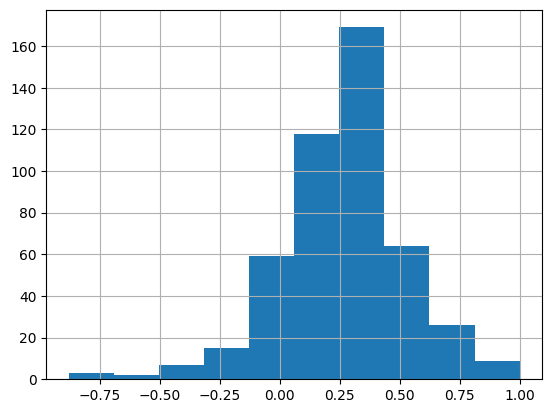

In [120]:
data['Review_textBlob_polarity'].hist()

Text(0, 0.5, 'Rating')

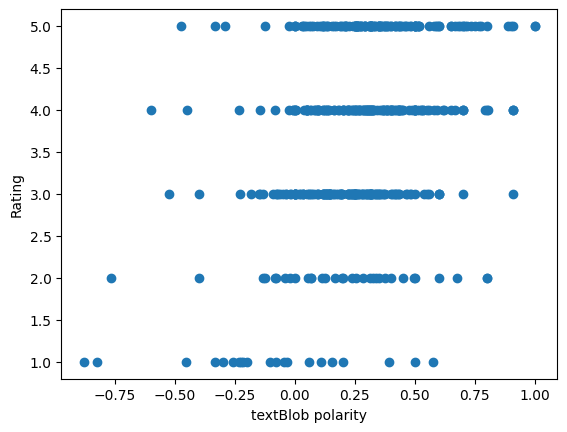

In [121]:
plt.scatter(data['Review_textBlob_polarity'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('textBlob polarity')
plt.ylabel('Rating')

In [122]:
# worst opinions
worst_opinions = (
    data
    .sort_values(by="Review_textBlob_polarity", ascending=True)
    .head(3)[["Review", "Review_textBlob_polarity"]]
)

worst_opinions

,Review,Review_textBlob_polarity
23,My God I did the biggest mistake in my life wo...,-0.880000
443,"Ugh, Mcdonalds was the worst experience of my ...",-0.825000
215,Horrible environment. They don't care about th...,-0.766667


In [123]:
# best opinions
best_opinions = (
    data
    .sort_values(by="Review_textBlob_polarity", ascending=False)
    .head(3)[["Review", "Review_textBlob_polarity"]]
)

best_opinions

,Review,Review_textBlob_polarity
151,my experience at mcdonalds was perfect and all...,1.00
272,It was a very great work environment in the wa...,1.00
460,Very good. Very good.,0.91


### 5. VADER

In [127]:
# VADER (Valence Aware Dictionary and sEntiment Reasoner) is a popular sentiment analysis tool that can work both at the level of single words and whole sentences;
# it aims at higher effectiveness in analysing specifically social media content as it introduces plenty of minor specificities into its dictionary such as abbreviations, 
# slang, emoticons. Also, it appears to work better with shorter texts; it returns negative, neutral, and positive (each component can take values from 0 to 1, yet all sum up to 1) 
# sentiment scores, along with the overall score of a text (compound, takes values from -1 to +1)

text = "I hate programming in Python, R is much better"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.319, 'neu': 0.431, 'pos': 0.25, 'compound': -0.2023}

In [129]:
# the below demonstrates that VADER is not based on (only) summing up per word (or token) scores and scalling them; in fact, VADER modifies predefined sentiment values
# for words and expressions by analysing their context (e.g. intensifiers, negation, punctuation, capital letters). The whole thing is much more developed than with, 
# for example, TextBlob

for token in text.split(' '):
    sentiment = sia.polarity_scores(token); print(token,'-','negative:',sentiment['neg'],'neutral:',sentiment['neu'],'positive:',sentiment['pos'],'compound:',sentiment['compound'])

I - negative: 0.0 neutral: 0.0 positive: 0.0 compound: 0.0
hate - negative: 1.0 neutral: 0.0 positive: 0.0 compound: -0.5719
programming - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
in - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
Python, - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
R - negative: 0.0 neutral: 0.0 positive: 0.0 compound: 0.0
is - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
much - negative: 0.0 neutral: 1.0 positive: 0.0 compound: 0.0
better - negative: 0.0 neutral: 0.0 positive: 1.0 compound: 0.4404


In [130]:
text = "I hate programming in Python, R is much better!"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.336, 'neu': 0.42, 'pos': 0.244, 'compound': -0.2714}

In [131]:
text = "I HATE PROGRAMMING IN PYTHON, R IS MUCH BETTER!"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.336, 'neu': 0.42, 'pos': 0.244, 'compound': -0.2714}

In [132]:
text = "I HATE programming in Python, R is much better!"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.374, 'neu': 0.396, 'pos': 0.23, 'compound': -0.4263}

In [133]:
text = "I HATE programming in Python, R is much better! >.<''"

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text)
sentiment_scores

{'neg': 0.347, 'neu': 0.44, 'pos': 0.213, 'compound': -0.4263}

In [134]:
# applying VADER to the analysed reviews:

print('Review #15:',data['Review'][15])

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(data['Review'][15])
sentiment_scores

Review #15: The job is actually fun, but it can be very challenging and high-paced. Extremely high-paced. The job has allowed me to meet more people and learn to step out of my comfort zone. I've learned how to handle customer service situations and overall, just gain lots of experience needed for future jobs.


{'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.907}

In [135]:
print('Review #25:',data['Review'][25])

sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(data['Review'][25])
sentiment_scores

Review #25: Well my experience in mcDonald's are great. First because it has give me the opportunity to meet new people from different backgrounds and different cultures as well it had provide the ability to grow as a person. I like to interact with a lot of people which i always try to do my best for my job, customer and myself.


{'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.959}

In [136]:
def vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

data['Review_vader_compound'] = data['Review'].apply(vader)

In [137]:
data['Review_vader_compound'].describe()

count    472.000000
mean       0.530029
std        0.540062
min       -0.978200
25%        0.361200
50%        0.807200
75%        0.900025
max        0.987800
Name: Review_vader_compound, dtype: float64

<Axes: >

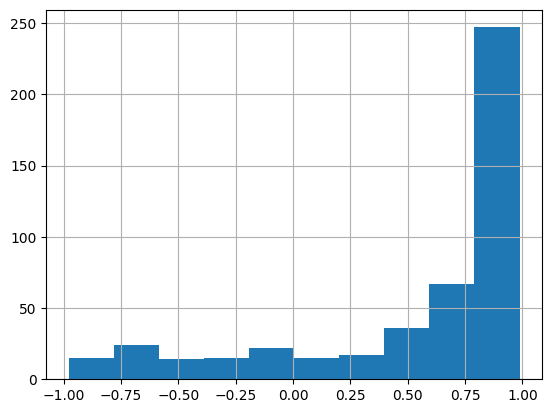

In [138]:
data['Review_vader_compound'].hist()

Text(0, 0.5, 'Rating')

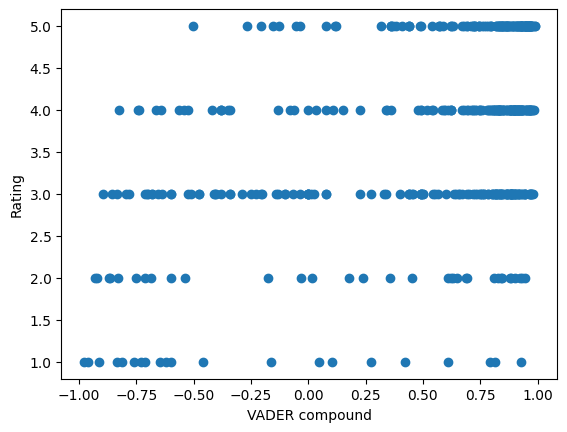

In [139]:
plt.scatter(data['Review_vader_compound'], pd.to_numeric(data['Rating'].map(lambda x: x.split('Rating ')[1].split(' out of ')[0])))
plt.xlabel('VADER compound')
plt.ylabel('Rating')

In [140]:
# worst opinions
worst_opinions = (
    data
    .sort_values(by="Review_AFINN_sentiment", ascending=True)
    .head(3)[["Review", "Review_AFINN_sentiment"]]
)

worst_opinions

,Review,Review_AFINN_sentiment
443,"Ugh, Mcdonalds was the worst experience of my ...",-20.0
451,I worked at McDonald's for three months and it...,-15.0
23,My God I did the biggest mistake in my life wo...,-11.0


In [141]:
# best opinions
best_opinions = (
    data
    .sort_values(by="Review_AFINN_sentiment", ascending=False)
    .head(3)[["Review", "Review_AFINN_sentiment"]]
)

best_opinions

,Review,Review_AFINN_sentiment
11,Not great.Not great.Not great.Not great.Not gr...,33.0
46,The work environment is very nice and the trea...,23.0
169,Very lovely been around for years the people a...,22.0
